# Researching the performance effects of offering services within different lifecycle contexts

This notebook presents analyses that I performed for my master thesis. For my study I conducted the following hypotheses: 

H1: Product-oriented servitization has a significant inverted U-shape relationship to firm performance in the early phases of the industry lifecycle

H2a: Product-oriented servitization has a significant negative relationship with firm performance in the mature industry lifecycle phase

H2b: Customer-oriented servitization has a significant inverted U-shape relationship with firm performance in the mature phase of the industry lifecycle

H3: The relationship between general servitization and firm performance is negatively moderated by the average length of product lifecycles within a firm’s industry, in such way that firm performance positively increases when product lifecycle lengths are short

To be able to understand the meaning of my hypotheses it is important to take notice of the definitions of concepts: 
Product-oriented servicitization is the extend to which manufacturing companies offer services that are performed on the product, such as repair.
Customer-oriented servitization is the extend to which manufacturing companies offer services that are performed on the customer, such as consultancy services. 
Servitization is the extend to which manufacturing companies offer services in general (both PO- and CO-services).
Industry lifecycle is the lifecycle of an industry, starting with growth until it reaches a peak and matures. 
Product lifecycle length is the average time that products in a specific industry are sold. E.g. aerospace industry have longer PLC_length compared to the computer industry. 
Firm performance in this study is measured by profit as EBITDA margin. 



In [80]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import pearsonr
import statsmodels.api as sm #Importing all necessary libraries

## Importing and cleaning dataframe

In this part, I import the final dataframe that I used for hypotheses testing during my thesis. I gathered all the data from the Compustat and Patentsview databases. After that I performed most of the data cleaning and feature engineering in another software programme. Many of the features in this dataframe are not longer necessary for my hypotheses testing, therefore I remove these features first. At last I split my dataframe into two, dfEarly includes all companies in the early industry lifecycle and dfMature includes all companies in the mature industry lifecycle. 

In [81]:
df = pd.read_csv('Dataset_thesis_30062020.csv', sep=";", decimal='.').set_index('ID').sort_index() #creating dataframe from thesis dataset

In [82]:
df.head()

,conm,sic,gvkey,Year,Product_Srev,PO_servRev,CO_servRev,EBITDA,EMPL,Tot_Rev,...,DummyCOserv,Ebitda_Mrgn,IND_maturity_Mrgn,PLC_phase,DummyMaturity,CO_SQRDservitization,PO_SQRDservitization,Dummy_empl,filter_$,Gen_SQRDservitization
ID,,,,,,,,,,,,,,,,,,,,,
13,ACTIVISION BLIZZARD INC,7372,180405,12/31/2011,4071,0,418,1771,"7,3",4755,...,1,"37,2450052576236","-4,07407407407407",1,1,"86,7068387907551",0,10,1,"86,7068387907551"
14,ACTIVISION BLIZZARD INC,7372,180405,12/31/2012,4681,0,306,1776,"6,7",4856,...,1,"36,5733113673806","-1,15830115830116",1,1,"37,6499250970108",0,10,1,"37,6499250970108"
15,ACTIVISION BLIZZARD INC,7372,180405,12/31/2013,4019,0,323,1675,"6,9",4583,...,1,"36,5481125900065","-5,078125",1,1,"55,3382481396559",0,10,1,"55,3382481396559"
16,ACTIVISION BLIZZARD INC,7372,180405,12/31/2014,4406,0,407,1544,"6,8",4408,...,1,"35,02722323049","-7,40740740740741",1,1,"71,5084056447475",0,10,1,"71,5084056447475"
17,ACTIVISION BLIZZARD INC,7372,180405,12/31/2015,4621,0,0,1829,"7,3",4664,...,1,"39,2152658662093",-12,2,1,0,0,10,1,0


In [83]:
del df['sic']
del df['gvkey']
del df['Product_Srev']
del df['PO_servRev']
del df['CO_servRev']
del df['EBITDA']
del df['Tot_Rev']
del df['Tot_Srev']
del df['Act_F_Ind']
del df['Diff_Act_F_IND']
del df['Dummy_empl']
del df['IND_maturity_Mrgn'] # delete all features that are not relevant for hypothesis testing.

In [84]:
df['EMPL'] = df['EMPL'].apply(lambda x: x.replace(',','.'))
df['PLC_Length'] = df['PLC_Length'].apply(lambda x: x.replace(',','.'))
df['AvgIND_EBITDAmargn'] = df['AvgIND_EBITDAmargn'].apply(lambda x: x.replace(',','.'))
df['Gen_servitization'] = df['Gen_servitization'].apply(lambda x: x.replace(',','.'))
df['PO_servitization'] = df['PO_servitization'].apply(lambda x: x.replace(',','.'))
df['CO_servitization'] = df['CO_servitization'].apply(lambda x: x.replace(',','.'))
df['Ebitda_Mrgn'] = df['Ebitda_Mrgn'].apply(lambda x: x.replace(',','.'))
df['CO_SQRDservitization'] = df['CO_SQRDservitization'].apply(lambda x: x.replace(',','.'))
df['PO_SQRDservitization'] = df['PO_SQRDservitization'].apply(lambda x: x.replace(',','.'))
df['Gen_SQRDservitization'] = df['Gen_SQRDservitization'].apply(lambda x: x.replace(',','.')) #change comma to dot as decimal operator

In [85]:
df.dtypes #check all existent data tpyes

conm                     object
Year                     object
EMPL                     object
PLC_Length               object
AvgIND_EBITDAmargn       object
Gen_servitization        object
PO_servitization         object
DummyPOserv               int64
CO_servitization         object
DummyCOserv               int64
Ebitda_Mrgn              object
PLC_phase                 int64
DummyMaturity             int64
CO_SQRDservitization     object
PO_SQRDservitization     object
filter_$                  int64
Gen_SQRDservitization    object
dtype: object

In [86]:
df['conm'] = df['conm'].astype(str)
df['Year'] =  pd.to_datetime(df['Year'], infer_datetime_format=True)
df['EMPL'] = pd.to_numeric(df['EMPL'], errors='coerce')
df['PLC_Length'] = pd.to_numeric(df['PLC_Length'], errors='coerce')
df['AvgIND_EBITDAmargn'] = pd.to_numeric(df['AvgIND_EBITDAmargn'], errors='coerce')
df['Gen_servitization'] = pd.to_numeric(df['Gen_servitization'], errors='coerce')
df['PO_servitization'] = pd.to_numeric(df['PO_servitization'], errors='coerce')
df['CO_servitization'] = pd.to_numeric(df['CO_servitization'], errors='coerce')
df['Ebitda_Mrgn'] = pd.to_numeric(df['Ebitda_Mrgn'], errors='coerce')
df['CO_SQRDservitization'] = pd.to_numeric(df['CO_SQRDservitization'], errors='coerce')
df['PO_SQRDservitization'] = pd.to_numeric(df['PO_SQRDservitization'], errors='coerce')
df['Gen_SQRDservitization'] = pd.to_numeric(df['Gen_SQRDservitization'], errors='coerce') #change all numeric object data types to correct data type

In [87]:
df.dtypes

conm                             object
Year                     datetime64[ns]
EMPL                            float64
PLC_Length                      float64
AvgIND_EBITDAmargn              float64
Gen_servitization               float64
PO_servitization                float64
DummyPOserv                       int64
CO_servitization                float64
DummyCOserv                       int64
Ebitda_Mrgn                     float64
PLC_phase                         int64
DummyMaturity                     int64
CO_SQRDservitization            float64
PO_SQRDservitization            float64
filter_$                          int64
Gen_SQRDservitization           float64
dtype: object

In [88]:
dfEarly = df[~(df['DummyMaturity'] > 0)]
dfMature = df[~(df['DummyMaturity'] < 1)] # split the dataframe in a dataframe for companies in the early industry lifecycle and into a dataframe for companies in the mature industry lifecycle

## Correlations

In this part I provide the correlations and their significance between the features included in my models for hypotheses testing. AvgIND_EBITDAmargn is significantly correlated and used as a control variable during my hypotheses testing. : 

Firm yearly performance measured by Ebitda margin = Ebitda_Mrgn.

General servitization(both PO- and CO-services) = Gen_servitization.

Product-oriented servitization = PO_servitization.

Customer-oriented servitization = CO-servitization.

Average length of product lifecycle within an industry = PLC_length.

Average performance of firms in a particular industry = AvgIND_EBITDAmargn.

In [89]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1] #create function to compute the P-value of a correlation 

In [90]:
c = df[['Ebitda_Mrgn','Gen_servitization', 'PO_servitization', 'CO_servitization', 'PLC_Length', 'AvgIND_EBITDAmargn']]
pval = c.corr(method=pearsonr_pval).round(3)
c = c.corr().round(1)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05] if x<=t]))
corrTable = c.astype(str) + p
corrTable #create a correlation table with *'s as significance indicators

,Ebitda_Mrgn,Gen_servitization,PO_servitization,CO_servitization,PLC_Length,AvgIND_EBITDAmargn
Ebitda_Mrgn,1.0,-0.1,-0.1,-0.0,-0.1**,0.3**
Gen_servitization,-0.1,1.0,0.9**,0.1**,-0.0,0.1**
PO_servitization,-0.1,0.9**,1.0,-0.3**,0.1,0.1*
CO_servitization,-0.0,0.1**,-0.3**,1.0,-0.2**,0.1**
PLC_Length,-0.1**,-0.0,0.1,-0.2**,1.0,-0.5**
AvgIND_EBITDAmargn,0.3**,0.1**,0.1*,0.1**,-0.5**,1.0


The AvgIND_EBITDAmargn is significantly correlated to the dependent variable Ebitda_Mrgn. This variable will be used as a control variable in the analyses, as it controls for differences in competition intensity of all industries in the study's sample.

## Hypotheses testing

In this part I test all my four hypotheses. For each hypothesis I start with a model summary to check for a significant relationship. If a significant relationship is existent I check if the model is better in reducing variance compared to another model (linear vs curvilinear). If this is the case, I accept my hypothesis and start with visualizing my model. For the visualization I fit a slightly different model, because I do not include my control variable, AvgIND_EBITDAmargn. The reason for this is that I want a smooth line as visualization and I already controlled for this variable during my hypothesis test. 

#### H1

In [91]:
X = dfEarly[['AvgIND_EBITDAmargn','PO_servitization','PO_SQRDservitization']]
X= X.to_numpy()
y= dfEarly['Ebitda_Mrgn']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary() # Testing H1, assuming a curvilinear relationship between PO_servitization and firm performance(EBITDA_Mrgn) in the early industry lifecycle. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Ebitda_Mrgn   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.667
Date:                Fri, 18 Dec 2020   Prob (F-statistic):             0.0487
Time:                        15:16:19   Log-Likelihood:                -776.59
No. Observations:                 222   AIC:                             1561.
Df Residuals:                     218   BIC:                             1575.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3580      1.509      7.527      0.000       8.384      14.332
x1             0.0863      0.090      0.962      0.337      -0.090       0.263
x2             0.2123      0.090      2.348      0.020       0.034       0.390
x3            -0.0036      0.002     -2.174      0.031      -0.007      -0.000
==============================================================================
Omnibus:                        5.847   Durbin-Watson:                   0.996
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                7.785
Skew:                          -0.150   Prob(JB):                       0.0204
Kurtosis:                       3.867   Cond. No.                     2.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### X3 (the squared PO-servitization feature) indicates that a negative curvilinear relationship(inverted-U) between PO_servitization and firm performance is existent and significant when controlling for x1 (Avgindustry EBITDA margin) and x2(linear PO-servitization) (ß = - .0036, p < .05). However, it could still be that my curvilinear model is not a better predictor than just a regular linear model.  

In [92]:
Xlin = dfEarly[['AvgIND_EBITDAmargn','PO_servitization']]
Xlin= Xlin.to_numpy()
y= dfEarly['Ebitda_Mrgn']
model2 = sm.OLS(y, sm.add_constant(Xlin)).fit()
print(model2.rsquared, model2.rsquared_adj)
print(model.rsquared, model.rsquared_adj) #computing R-squared values for linear and curvilinear model

0.014484970535496244 0.005484833280112511
0.03539819376864761 0.02212385698564734


The adjusted R-square of my curvilinear model is higher than the adjusted R-square of my linear model, therefore I may conclude that my curvilinear model is a signicantly better predictor than the linear model. Thus, H1 is supported. There is an inverted U shape relationship between PO-servitization and firm perfomance for companies in the early industry lifecycle phase. 

In [93]:
X = dfEarly[['PO_servitization','PO_SQRDservitization']]
X= X.to_numpy()
y= dfEarly['Ebitda_Mrgn']
modelVisual = sm.OLS(y, sm.add_constant(X)).fit()
modelVisual.params #getting the parameters of the curvilinear model without the AvgIND_EBITDAmargn as control variable, in order to get a smooth model for visualization. 

const    12.634787
x1        0.233305
x2       -0.003946
dtype: float64

In [94]:
dfEarly['yPredict'] = 11.357963+0.233305*dfEarly['PO_servitization']-0.003946*(dfEarly['PO_servitization']**2) # predicting y values with my linear model

<ipython-input-94-b042bdbe7bba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfEarly['yPredict'] = 11.357963+0.233305*dfEarly['PO_servitization']-0.003946*(dfEarly['PO_servitization']**2) # predicting y values with my visualization model


In [95]:
Ebitda_Mrgn = dfEarly['Ebitda_Mrgn']
x = dfEarly['PO_servitization']
y = dfEarly['yPredict']
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0])) # creating variables for plotting a smooth line through the predicted values of my model. 

Text(0.5, 1.0, 'model visualization')

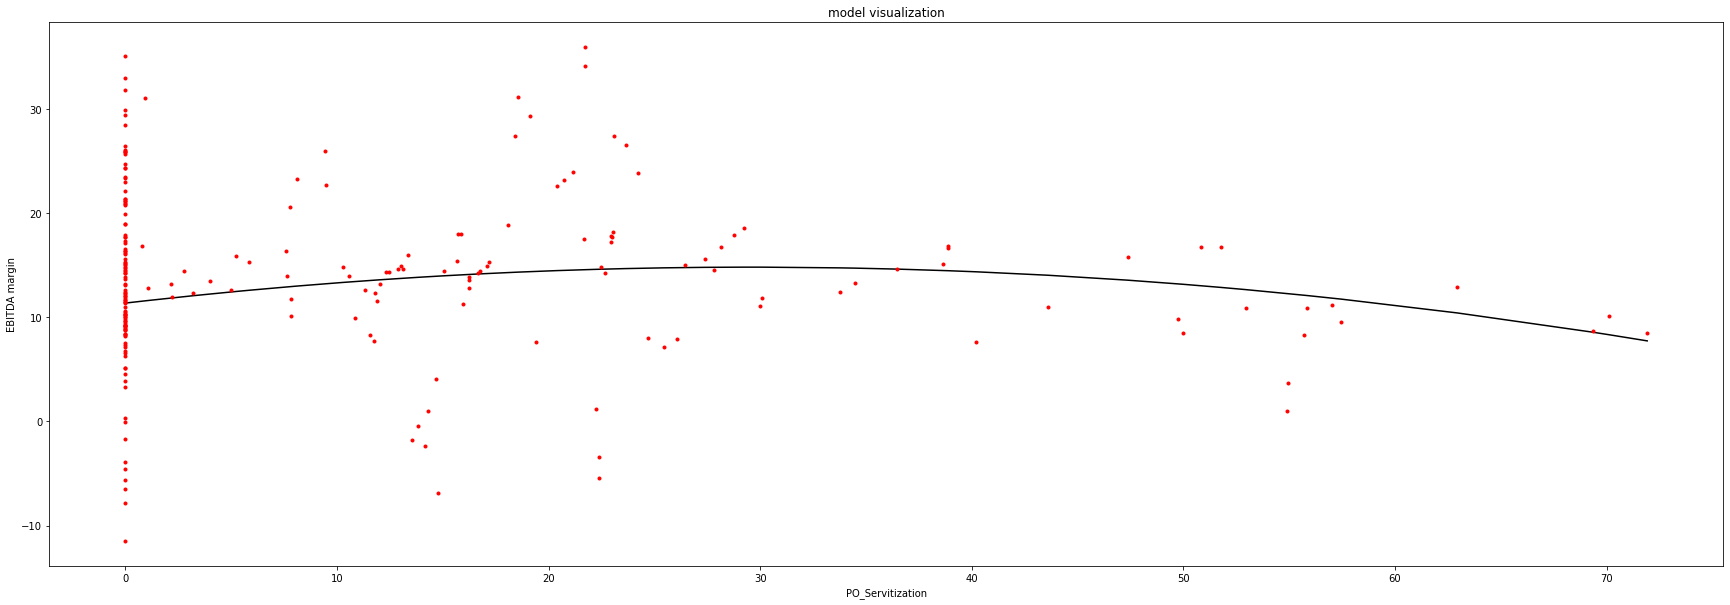

In [96]:
plt.figure(figsize=(30,10))
plt.plot(x2,y2, color= "black",)
plt.plot(x2, Ebitda_Mrgn, ".", color='red')
plt.xlabel("PO_Servitization")
plt.ylabel("EBITDA margin")
plt.title("model visualization") #visualizing my model as a line plot and the true datapoints as a scatterplot.

The graph shows that my model does indeed visualize a negative curvilinear relationship between PO-servitization and firm performance(EBITDA margin) in the early industry lifecycle phase. It seems that companies are likely to benefit from product oriented services until more than 30-40% of their revenues are coming from product-oriented services. 

#### H2a

In [97]:
X = dfMature[['AvgIND_EBITDAmargn','PO_servitization']]
X= X.to_numpy()
y= dfMature['Ebitda_Mrgn']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary() #testing H2a, assuming a negative linear relationship between PO-servitization and firm performance(EBITDA_Mrgn) in the mature industry lifecycle.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Ebitda_Mrgn   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     30.79
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           3.85e-13
Time:                        15:16:21   Log-Likelihood:                -1436.0
No. Observations:                 392   AIC:                             2878.
Df Residuals:                     389   BIC:                             2890.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9374      1.095      6.335      0.000       4.785       9.090
x1             0.4546      0.061      7.476      0.000       0.335       0.574
x2            -0.0809      0.026     -3.117      0.002      -0.132      -0.030
==============================================================================
Omnibus:                        6.516   Durbin-Watson:                   0.751
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.562
Skew:                          -0.251   Prob(JB):                       0.0376
Kurtosis:                       3.386   Cond. No.                         61.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### X2 (the PO-servitization feature) indicates that a negative linear relationship is existent and significant when controlling for x1 (AvgIND_EBITDAmargn) (ß = - 0.0809, p < .01). However, it could still be that my linear model is not a better predictor than a curvilinear model.

In [98]:
Xcurve = dfMature[['AvgIND_EBITDAmargn','PO_servitization', 'PO_SQRDservitization']]
Xcurve= Xcurve.to_numpy()
y= dfMature['Ebitda_Mrgn']
model2 = sm.OLS(y, sm.add_constant(Xcurve)).fit()
print(model2.rsquared, model2.rsquared_adj)
print(model.rsquared, model.rsquared_adj) #computing R-squared values for linear and curvilinear model

0.1387109949429094 0.13205154387288032
0.1366762373990833 0.13223755481501687


The adjusted R-square of my linear model is higher than the adjusted R-square of my curvilinear model, therefore I may conclude that my curvilinear model is a signicantly better predictor than the linear model. Thus, H2a is supported. There is a negative linear relationship between PO-servitization and firm perfomance for companies in the mature industry lifecycle phase.

In [99]:
X = dfMature[['PO_servitization']]
X= X.to_numpy()
y= dfMature['Ebitda_Mrgn']
modelVisual = sm.OLS(y, sm.add_constant(X)).fit()
modelVisual.params #getting the parameters of a linear model without the AvgIND_EBITDAmargn as control variable, in order to get a smooth model for visualization. 

const    13.729592
x1       -0.061620
dtype: float64

In [100]:
dfMature['yPredict'] = 13.729592-0.061620*dfMature['PO_servitization'] #predicting the y values with my linear model for visualization 

<ipython-input-100-db4c49af1874>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMature['yPredict'] = 13.729592-0.061620*dfMature['PO_servitization'] #predicting the y values with my linear model for visualization


In [101]:
Ebitda_Mrgn = dfMature['Ebitda_Mrgn']
x = dfMature['PO_servitization']
y = dfMature['yPredict']
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0])) #creating variables for plotting a smooth line through the predicted values of my model.

Text(0.5, 1.0, 'model visualization')

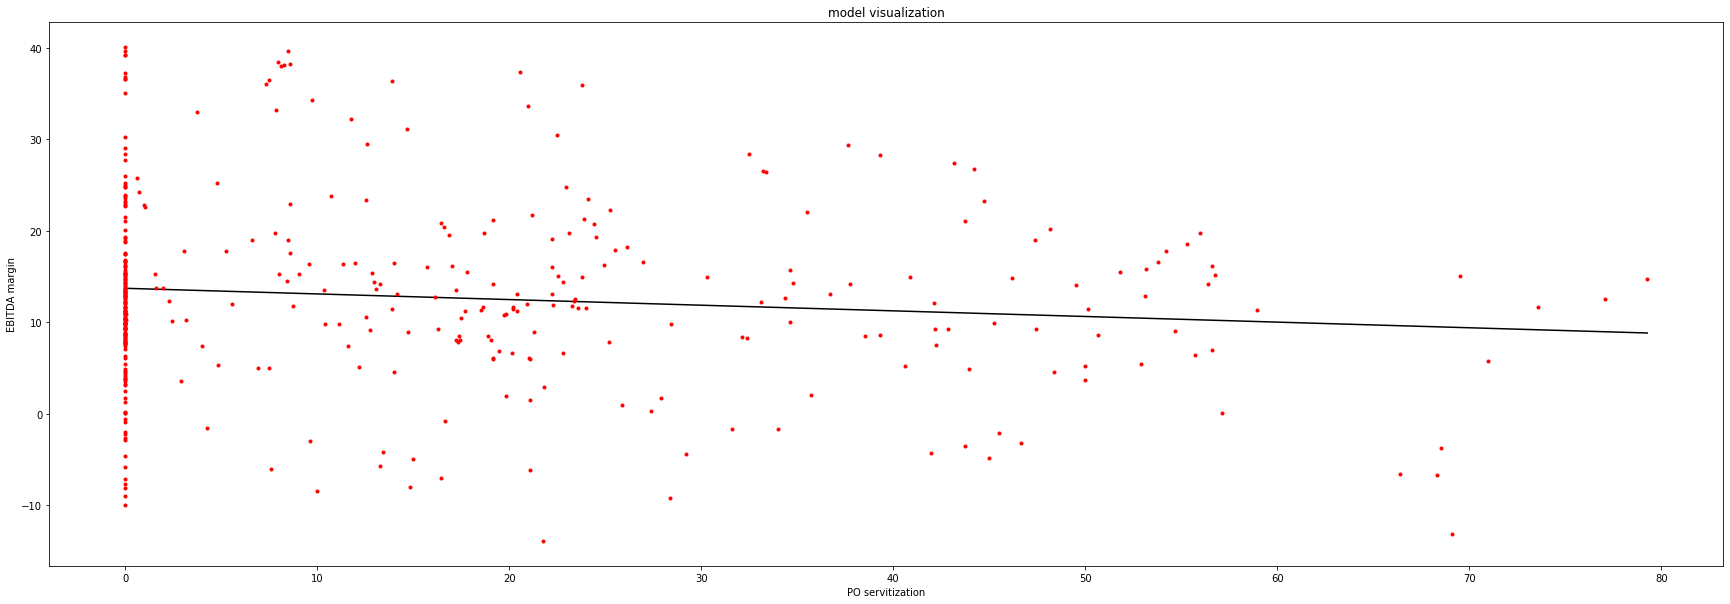

In [102]:
plt.figure(figsize=(30,10))
plt.plot(x2,y2, color= "black",)
plt.plot(x, Ebitda_Mrgn, ".", color='red')
plt.xlabel("PO servitization")
plt.ylabel("EBITDA margin")
plt.title("model visualization") #visualizing my model as a line plot and the true datapoints as a scatterplot.

The graph shows that my model does indeed visualize a negative linear realtionship between PO-servitization and firm performance(EBITDA margin) in the mature industry lifecycle phase. It seems that companies in a mature industry are not likely to get any benefits when offering product-oriented services. 

#### H2b

In [103]:
dfMatureCO = dfMature[~(dfMature['DummyCOserv'] < 1)] # removing companies that have not reported CO-services in the past 8 years.

In [104]:
X = dfMatureCO[['AvgIND_EBITDAmargn','CO_servitization','CO_SQRDservitization']]
X= X.to_numpy()
y= dfMatureCO['Ebitda_Mrgn']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary() #Testing H2b, assuming a negative curvilinear relationship between CO-servitization and firm performance(EBITDA_Mrgn) in the mature industry lifecycle. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Ebitda_Mrgn   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     7.136
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           0.000153
Time:                        15:16:23   Log-Likelihood:                -611.80
No. Observations:                 174   AIC:                             1232.
Df Residuals:                     170   BIC:                             1244.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7133      1.571      3.637      0.000       2.612       8.815
x1             0.3720      0.095      3.923      0.000       0.185       0.559
x2             0.3879      0.203      1.910      0.058      -0.013       0.789
x3            -0.0130      0.006     -2.158      0.032      -0.025      -0.001
==============================================================================
Omnibus:                       12.446   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.263
Skew:                           0.418   Prob(JB):                     0.000108
Kurtosis:                       4.349   Cond. No.                         850.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### X3 (the squared CO-servitization feature) indicates that a negative curvilinear relationship between CO-servitization and firm performance(Ebitda margin) is existent and significant when controlling for x1 (Avgindustry EBITDA margin) and x2(linear CO-servitization) (ß = - 0.0130, p < .05). However, it could still be that my curvilinear model is not a better predictor than a linear model.

In [105]:
Xlin = dfMatureCO[['AvgIND_EBITDAmargn','CO_servitization']]
Xlin= Xlin.to_numpy()
y= dfMatureCO['Ebitda_Mrgn']
model2 = sm.OLS(y, sm.add_constant(Xlin)).fit()
print(model2.rsquared, model2.rsquared_adj)
print(model.rsquared, model.rsquared_adj) #computing R-squared values for linear and curvilinear model

0.08751026651768223 0.07683787197402925
0.11184355945960933 0.09617021050889663


The adjusted R-square of my curvilinear model is higher than the adjusted R-square of my linear model, therefore I may conclude that my curvilinear model is a signicantly better predictor than the linear model. Thus, H2b is supported. There is a negative curvilinear relationship (inverted-U) between CO-servitization and firm perfomance for companies in the mature industry lifecycle phase.

In [106]:
X = dfMatureCO[['CO_servitization','CO_SQRDservitization']]
X= X.to_numpy()
y= dfMatureCO['Ebitda_Mrgn']
modelVisual = sm.OLS(y, sm.add_constant(X)).fit()
modelVisual.params #getting the parameters of a curvilinear model without the AvgIND_EBITDAmargn as control variable, in order to get a smooth model for visualization. 

const    10.320485
x1        0.491300
x2       -0.013276
dtype: float64

In [107]:
dfMatureCO['yPredict'] = 10.320485+0.491300*dfMatureCO['CO_servitization']-0.013276*(dfMatureCO['CO_servitization']**2) 
#predicting the y values with my curvilinear model.

<ipython-input-107-514e1163c8d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMatureCO['yPredict'] = 10.320485+0.491300*dfMatureCO['CO_servitization']-0.013276*(dfMatureCO['CO_servitization']**2)


In [108]:
Ebitda_Mrgn = dfMatureCO['Ebitda_Mrgn']
x = dfMatureCO['CO_servitization']
y = dfMatureCO['yPredict']
x2,y2 = zip(*sorted(zip(x,y),key=lambda x: x[0])) #creating variables for plotting a smooth line through the predicted values of my model.

Text(0.5, 1.0, 'model visualization')

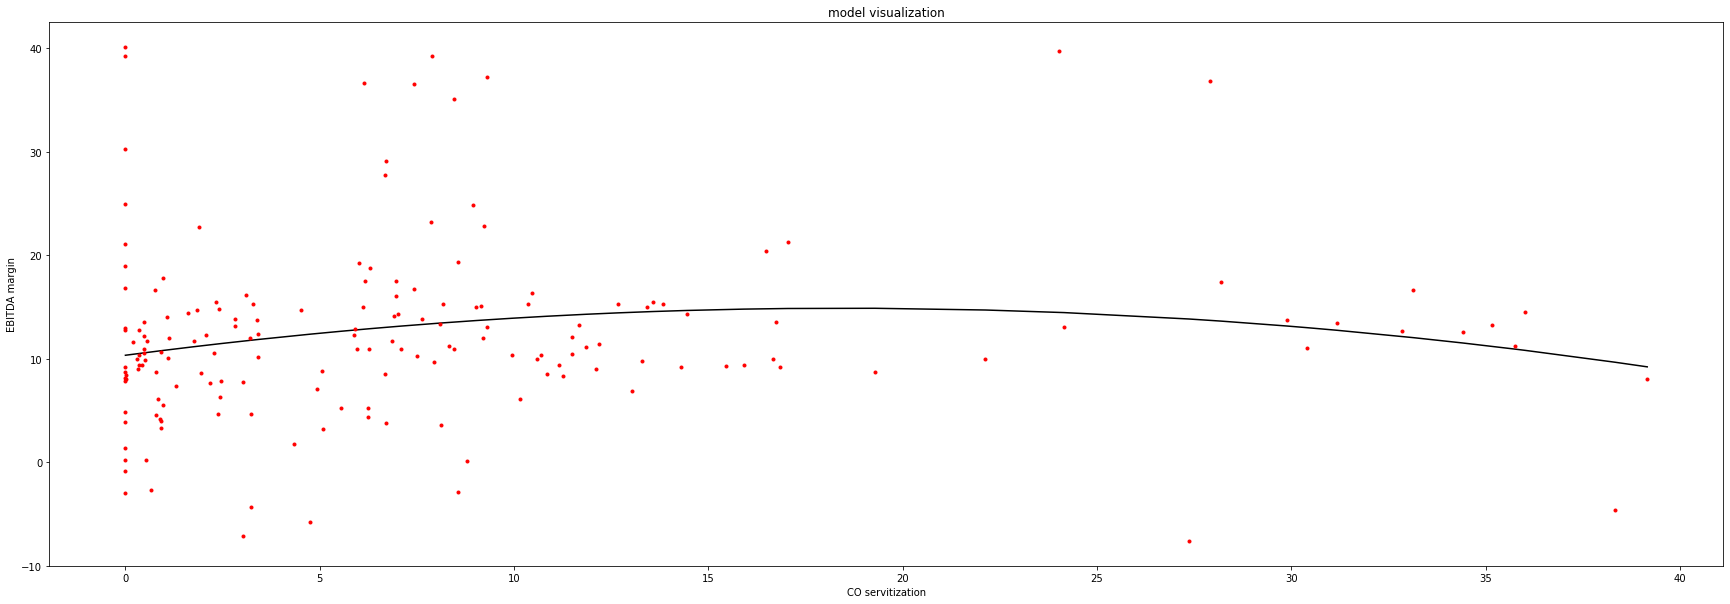

In [109]:
plt.figure(figsize=(30,10))
plt.plot(x2,y2, color= "black",)
plt.plot(x, Ebitda_Mrgn, ".", color='red')
plt.xlabel('CO servitization')
plt.ylabel('EBITDA margin')
plt.title('model visualization') #visualizing my model as a line plot and the true datapoints as a scatterplot.

The graph shows that my model does indeed visualize a negative curvilinear relationship(inverted-U) between CO-servitization and firm performance(EBITDA margin) in the mature industry lifecycle phase. It seems that companies in the mature industries are likely to benefit from customer-oriented services until more than 20-25% of their revenues are coming from customer-oriented services. 

### H3

In [110]:
df['PLC_Length'].isnull().sum() #counting missing values for PLC_Length

60

In [111]:
df = df.dropna() #removing missing values for PLC_Length

In [112]:
df['modVar'] = df['Gen_servitization']*df['PLC_Length'] # computing a moderation feature

In [113]:
X = df[['AvgIND_EBITDAmargn','Gen_SQRDservitization','modVar']]
X= X.to_numpy()
y= df['Ebitda_Mrgn']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary() #Testing H3, assuming a moderation effect of PLC_length on the relationship between servitization and firm performance(EBITDA_Mrgn).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Ebitda_Mrgn   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.813
Date:                Fri, 18 Dec 2020   Prob (F-statistic):             0.0388
Time:                        15:16:26   Log-Likelihood:                -1907.4
No. Observations:                 543   AIC:                             3823.
Df Residuals:                     539   BIC:                             3840.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0508      0.973     10.325      0.000       8.139      11.963
x1             0.1589      0.058      2.754      0.006       0.046       0.272
x2            -0.0002      0.001     -0.222      0.824      -0.002       0.002
x3            -0.0007      0.004     -0.190      0.850      -0.008       0.006
==============================================================================
Omnibus:                       11.588   Durbin-Watson:                   0.747
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               17.368
Skew:                          -0.162   Prob(JB):                     0.000169
Kurtosis:                       3.814   Cond. No.                     3.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### X3 (moderation variable) indicates that a moderation effect of PLC_Length on the relationship between servitization and firm performance(Ebitda marign) is insignificant (ß = - 0.0007, p > .05).  